# Serie-opteller

We maken met de microbit een serie-opteller, voor het optellen van twee binaire getallen.
Deze getallen kunnen willekeurig lang zijn.
Voor het optellen van twee binaire getallen X en Y voer je steeds het volgende bit van X en het bijbehorende bit van Y in; daarbij werk je van rechts naar links. (Op dezelfde manier als wanneer je twee decimale getallen optelt.)

Voorbeeld: X = 101, Y = 011, invoer: 1,1 (meest rechtse bits van X en Y), 0, 1, 1, 0.

Voor de invoer van een bit gebruik je de knoppen A(0) en B(1). Het bovenstaande voorbeeld wordt dan: B, B, A, B, B, A.

Zodra je weer twee bits ingevoerd hebt, verschijnt op het display het resultaat van de optelling, en schuift de invoer en uitvoer een positie naar rechts. Uiteindelijk schuift dit "uit het display", omdat dit maar een beperkte breedte heeft (5 posities).

We kunnen deze serie-opteller beschrijven met de volgende eindige automaat:

In [27]:
from IPython.display import SVG, display, Image
from pathlib import Path

In [28]:
digraph1 = '''
digraph serie_opteller {
    rankdir=LR;
    size="8,5"

    node [shape = doublecircle]; S;
    node [shape = point ]; qi

    node [shape = circle];
    qi -> S;
    S  -> q1 [ label = "a" ];
    S  -> S  [ label = "a" ];
    q1 -> S  [ label = "a" ];
    q1 -> q2 [ label = "b" ];
    q2 -> q1 [ label = "b" ];
    q2 -> q2 [ label = "b" ];
}
'''

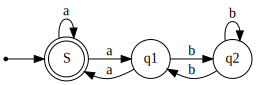

In [29]:
fig1 = !echo '{digraph1}' | dot -Tsvg 
display(SVG('\n'.join(fig1)))

In [33]:
digraph2 = '''
digraph serie_opteller {
    rankdir=LR;
    size="8,5"

    node [shape = doublecircle]; c0;
    node [shape = point ]; qi

    node [shape = circle];
    qi -> c0;
    c0  -> s0 [ label = "a" ];
    c0  -> s1 [ label = "b" ];
    s0 -> c0  [ label = "a/00" ];
    s0 -> c0  [ label = "b/01" ];
    s1 -> c0  [ label = "a/01" ];
    s1 -> c1  [ label = "b/10" ];
    c1  -> s1 [ label = "a" ];
    c1  -> s2 [ label = "b" ];
    s2 -> c1  [ label = "a/10" ];
    s2 -> c1  [ label = "b/11" ];  
}
'''

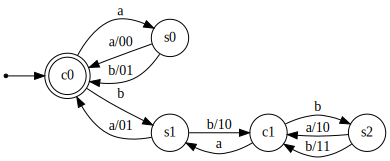

In [34]:
fig2 = !echo '{digraph2}' | dot -Tsvg
display(SVG('\n'.join(fig2)))

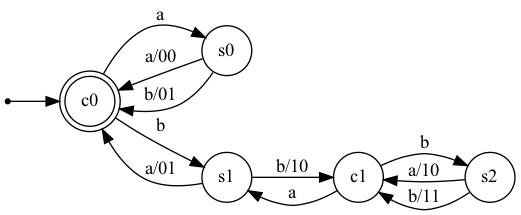

In [35]:
fig3 = !echo '{digraph2}' | dot -Tpng > serie-opteller.png
display(Image(filename='serie-opteller.png'))

Deze automaat kun je als volgt begrijpen:

* de toestanden c0 en c1 geven aan dat de "carry" (overdracht) van de vorige optelling 0 of 1 was. (c1 betekent: "1 onthouden" van de vorige optelling.)
* s0 staat voor "som tot nu toe: 0", na de invoer van 1 symbool, s1: "som is 1", s2: "som is 2"
* bij de invoer van elk 2e symbool vindt de output van de som plaats, en is de nieuwe toestand c0 of c1, afhankelijk van het cijfer dat onthouden moet worden.

In tabelvorm wordt dit:

| state | input | output | next   |
| :--   | :--   | :--    | :--    |
| c0    | a     |        | s0     |
| c0    | b     |        | s1     |
| s0    | a     | 0      | c0     |
| s0    | b     | 1      | c0     |
| s1    | a     | 1      | c0     |
| s1    | b     | 0      | c1     |
| c1    | a     |        | s1     |
| c1    | b     |        | s2     |
| s2    | a     | 0      | c1     |
| s2    | b     | 1      | c1     |

Reorganiseren van deze tabel geeft:

| state | input | output | next   |
| :--   | :--   | :--    | :--    |
| c0    | a     |        | s0     |
| s0    | a     | 0      | c0     |
| s1    | a     | 1      | c0     |
| c1    | a     |        | s1     |
| s2    | a     | 0      | c1     |
| c0    | b     |        | s1     |
| s0    | b     | 1      | c0     |
| s1    | b     | 0      | c1     |
| c1    | b     |        | s2     |
| s2    | b     | 1      | c1     |

```Python
def handle_a():
    if state == c0:
        state = s0
    elif state == s0:
        state = c0
        output_sum(0, 0)
    elif state == s1:
        state = c0
        output_sum(0, 1)
    elif state == c1:   
        state = s1
    elif state == s2:
        state = c1
        output_sum(1, 0)
        
def handle_b():
    if state == c0:
        state = s1
    elif state == s0:
        state = c0
        output_sum(0, 1)
    elif state == s1:
        state = c1
        output_sum(1, 0)
    elif state == c1:   
        state = s2
    elif state == s2:
        state = c1
        output_sum(1, 1)
```

```Python
from microbit import *

even = True
inputs_x = [0, 0, 0, 0, 0]
inputs_y = [0, 0, 0, 0, 0]
outputs = [0, 0, 0, 0, 0]

def input_bit(bit):
    global even
    even = not even
    if not even:
        inputs_x[0] = bit
        display.set_pixel(0,0, bit)
    else:
        inputs_y[0] = bit
        display.set_pixel(0,1, bit) 

def output_sum(b1, b0):
    print(b1, ",", b0)
    outputs[0] = b0
    inputs_x.insert(0, 0)
    inputs_x.pop(5)
    inputs_y.insert(0, 0)
    inputs_y.pop(5)
    outputs.insert(0, b1)
    outputs.pop(5)    
    display_state()

def display_state():
    display.clear()
    for i in range(5):
        display.set_pixel(i, 0, inputs_x[i]*9)
        display.set_pixel(i, 1, inputs_y[i]*9)
        display.set_pixel(i, 3, outputs[i]*9)

c0 = 0   # states of the automaton
c1 = 1
s0 = 2
s1 = 3
s2 = 4

state = c0

def handle_a():
    global state
    input_bit(0)
    if state == c0:
        state = s0
    elif state == s0:
        state = c0
        output_sum(0, 0)
    elif state == s1:
        state = c0
        output_sum(0, 1)
    elif state == c1:   
        state = s1
    elif state == s2:
        state = c1
        output_sum(1, 0)
        
def handle_b():
    global state
    input_bit(1)
    if state == c0:
        state = s1
    elif state == s0:
        state = c0
        output_sum(0, 1)
    elif state == s1:
        state = c1
        output_sum(1, 0)
    elif state == c1:   
        state = s2
    elif state == s2:
        state = c1
        output_sum(1, 1)

def reset():
    global state, even
    state = c0
    even = True
    inputs_x = [0, 0, 0, 0, 0]
    inputs_y = [0, 0, 0, 0, 0]
    outputs = [0, 0, 0, 0, 0]
    display_state()

reset()
while True:
    if button_a.was_pressed():
        handle_a()
        display_state()
    if button_b.was_pressed():
        handle_b()
        display_state()
    if accelerometer.was_gesture("shake"):
        reset()
    sleep(20)
```

Opmerkingen:

* ik wil de input ook weergeven. Daarbij moeten we onderscheid maken tussen de "even" en de "oneven" inputs, dat wil zeggen, de inputs voor X en die voor Y. (Eigenlijk is dat een eigen state machine.)

```Python
even = True
inputs_x = [0, 0, 0, 0, 0]
inputs_y = [0, 0, 0, 0, 0]
outputs = [0, 0, 0, 0, 0]

def input_bit(bit)
    global even
    if even:
        even = False
        inputs_x[0] = bit
    else:
        even = True
        inputs_y[0] = bit

def output_sum(b1, b0):
    outputs[0] = b0
    inputs_x.insert(0, 0)
    inputs_x.pop(5)
    inputs_y.insert(0, 0)
    inputs_y.pop(5)
    outputs.insert(0, b1)
    outputs.pop(5)    
    display_state()

def display_state():
    display.clear()
    for i in range(5):
        display.set_pixel(i, 0, inputs_x[i]*9)
        display.set_pixel(i, 1, inputs_y[i]*9)
        displat.set_pixel(i, 3, outputs[i]*9)
```